### *EXPLORING MODEL*:

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import warnings
from tqdm import tqdm
## Graphics
import plotly.graph_objs as go
import seaborn as sns

# Modelling
from sklearn.metrics import roc_auc_score,roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.exceptions import UndefinedMetricWarning
## Statistics
from statistics import mean,stdev
## Print
from pprint import pprint
## import auxiliar functions
from model_functions import convert_float_to_int,preprocess_data,evaluate_models_roc,evaluate_models_accuracy,find_best_model_params

In [2]:
df = pd.read_csv(Path.cwd().parent / 'app' / 'data' / 'dados_simulados.csv')

In [3]:
df.head()

,Paciente,vc_tem_lesao_atualmente,idade_inicio_problema_atual,onde_lesao,tipo_cancer_paciente,algum_filho_tem_ou_teve_cancer,tipo_cancer_filho,pai_tem_ou_teve_cancer,tipo_cancer_pai,mae_tem_ou_teve_cancer,tipo_cancer_mae,avo_paterno_tem_ou_teve_cancer,tipo_cancer_avo_paterno,avo_paterna_tem_ou_teve_cancer,tipo_cancer_avo_paterna,avo_materno_tem_ou_teve_cancer,tipo_cancer_avo_materno,avo_materna_tem_ou_teve_cancer,tipo_cancer_avo_materna,resultado_teste_genetico
0,X1,0,NaN,NaN,NaN,1,3.0,1,5.0,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
1,X2,0,NaN,NaN,NaN,1,8.0,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
2,X3,0,NaN,NaN,NaN,0,NaN,1,7.0,0,NaN,0,NaN,0,NaN,1,10.0,0,NaN,0
3,X4,1,37.0,14.0,6.0,0,NaN,0,NaN,0,NaN,0,NaN,1,4.0,0,NaN,1,1.0,0
4,X5,0,NaN,NaN,NaN,0,NaN,0,NaN,1,2.0,1,11.0,0,NaN,1,5.0,0,NaN,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Paciente                        10000 non-null  object 
 1   vc_tem_lesao_atualmente         10000 non-null  int64  
 2   idade_inicio_problema_atual     2903 non-null   float64
 3   onde_lesao                      2903 non-null   float64
 4   tipo_cancer_paciente            2903 non-null   float64
 5   algum_filho_tem_ou_teve_cancer  10000 non-null  int64  
 6   tipo_cancer_filho               2925 non-null   float64
 7   pai_tem_ou_teve_cancer          10000 non-null  int64  
 8   tipo_cancer_pai                 2948 non-null   float64
 9   mae_tem_ou_teve_cancer          10000 non-null  int64  
 10  tipo_cancer_mae                 2963 non-null   float64
 11  avo_paterno_tem_ou_teve_cancer  10000 non-null  int64  
 12  tipo_cancer_avo_paterno         2

### Cleaning Data 

In [5]:
# Colunas converter float pra int
float_to_int_columns = [
    'onde_lesao',
    'tipo_cancer_paciente',
    'tipo_cancer_filho',
    'tipo_cancer_pai',
    'tipo_cancer_mae',
    'tipo_cancer_avo_paterno',
    'tipo_cancer_avo_paterna',
    'tipo_cancer_avo_materno',
    'tipo_cancer_avo_materna'
]
df=convert_float_to_int(df,float_to_int_columns)

### Pre-processing

In [6]:
X = df.drop(columns=['Paciente', 'resultado_teste_genetico']).copy()
y = df['resultado_teste_genetico'].copy()

In [7]:
# Lista de colunas numéricas
numerical_features = ['idade_inicio_problema_atual']
# Lista de colunas categóricas (excluindo as colunas mencionadas)
categorical_features = [col for col in df.columns if col not in ['resultado_teste_genetico', 'Paciente','idade_inicio_problema_atual']]

In [8]:
preprocessor = preprocess_data(numerical_features, categorical_features)

In [9]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['idade_inicio_problema_atual']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['vc_tem_lesao_atualmente', 'onde_lesao',
                                  'tip...
                                  'algum_filho_tem_ou_teve_cancer',
                                  'tipo_cancer_filho', 'pai_tem_ou_teve_cancer',
                                  'tipo_cancer_pai', 'mae_tem_ou_teve_cancer',
                                  'tipo_cancer_mae',
                                  'avo_paterno_tem_ou_teve_cancer',
                                  'tipo_cancer_avo_paterno',
                                  'avo_paterna_tem_ou_teve_cancer',
                                  'tipo_cancer_avo_paterna',
                                  'avo_materno_tem_ou_teve_cancer',
                                  'tipo_cancer_avo_materno',
                                  'avo_materna_tem_ou_teve_cancer',
                                  'tipo_cancer_avo_materna'])])

### Model Selection

In [10]:
models = {
    'LR': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'DTC': DecisionTreeClassifier(),
    'GBC': GradientBoostingClassifier(),
    'RF': RandomForestClassifier(),
}


In [11]:
results = evaluate_models_roc(X, y, models, preprocessor, n_splits=10)

In [12]:
pprint(results)

{'DTC': [0.5102991794324437,
         0.510626308066825,
         0.5156287495925815,
         0.5438543394090911,
         0.48625820955573784,
         0.4925220065640629,
         0.48691664547493946,
         0.49467819019067777,
         0.5244349569181139,
         0.511419057750143],
 'GBC': [0.6590836100196874,
         0.6620510487815652,
         0.636693207066456,
         0.6653193503750637,
         0.6582132568282133,
         0.6724457402240474,
         0.6467774844763134,
         0.6567561017250663,
         0.6723872391178989,
         0.6687046541808592],
 'KNN': [0.5656113783457558,
         0.5603606055938997,
         0.5621496649319297,
         0.5908384879971251,
         0.5648610121168924,
         0.5806187029230256,
         0.5787251773240162,
         0.578310893980475,
         0.5891843393732741,
         0.5597636555311603],
 'LR': [0.6633798596212233,
        0.6579685073024901,
        0.6341251278965508,
        0.662523236281192,
        0.6542095

In [13]:
# Comparação de curvas_roc
media_roc = {}
desvio_padrao_roc = {}
margem_erro_roc = {}

for modelo, acuracias in results.items():
    media_roc[modelo] = np.mean(acuracias)
    desvio_padrao_roc[modelo] = np.std(acuracias,ddof=1)
    margem_erro_roc[modelo] = 2.0 * desvio_padrao_roc[modelo] / np.sqrt(len(acuracias))


comparacao_modelos = pd.DataFrame({'Modelo': list(results.keys()),
                   'Média_Curva_ROC': list(media_roc.values()),
                   'Desvio_Padrao': list(desvio_padrao_roc.values()),
                   'Margem_Erro_ROC': list(margem_erro_roc.values())
                   })

comparacao_modelos

,Modelo,Média_Curva_ROC,Desvio_Padrao,Margem_Erro_ROC
0,LR,0.657255,0.011150,0.007052
1,KNN,0.573042,0.011892,0.007521
2,DTC,0.507664,0.018168,0.011491
3,GBC,0.659843,0.011299,0.007146
4,RF,0.615648,0.016298,0.010308


In [14]:
# Plotar os resultados
fig = go.Figure()

for name, result in results.items():
    fig.add_trace(go.Bar(
        x=[name],
        y=[mean(result)],
        error_y=dict(type='data', array=[2.0*stdev(result)/np.sqrt(len(result))]),
        name=name
    ))

fig.update_layout(
    title='Comparação Curva ROC',
    xaxis_title='Modelo',
    yaxis_title='AUC',
    width=1000,
    height=600,
)

fig.show()

In [15]:
results_acuracy = evaluate_models_accuracy(X, y, models, preprocessor, n_splits=10)

In [16]:
# Comparação de acurácias
media_acuracia = {}
desvio_padrao_acuracia = {}
margem_erro_acuracia = {}

for modelo, acuracias in results_acuracy.items():
    media_acuracia[modelo] = np.mean(acuracias)
    desvio_padrao_acuracia[modelo] = np.std(acuracias)
    margem_erro_acuracia[modelo] = 2.0 * desvio_padrao_acuracia[modelo] / np.sqrt(len(acuracias))

comparacao_modelos_acurracy = pd.DataFrame({
    'Modelo': list(results_acuracy.keys()),
    'Média_Acurácia': list(media_acuracia.values()),
    'Desvio_Padrao_Acurácia': list(desvio_padrao_acuracia.values()),
    'Margem_Erro_Acurácia': list(margem_erro_acuracia.values())
})

comparacao_modelos_acurracy

,Modelo,Média_Acurácia,Desvio_Padrao_Acurácia,Margem_Erro_Acurácia
0,LR,0.71265,0.008258,0.005223
1,KNN,0.67475,0.008436,0.005335
2,DTC,0.64340,0.011447,0.007240
3,GBC,0.71340,0.007703,0.004872
4,RF,0.68090,0.009653,0.006105


In [17]:
# Plotar os resultados
fig = go.Figure()

for name, result in results_acuracy.items():
    fig.add_trace(go.Bar(
        x=[name],
        y=[mean(result)],
        error_y=dict(type='data', array=[2.0*stdev(result)/np.sqrt(len(result))]),
        name=name
    ))

fig.update_layout(
    title='Comparação de Acurácias',
    xaxis_title='Modelo',
    yaxis_title='Acurácia Média',
    width=1000,
    height=600,
)

fig.show()

### Split Train-Test

In [18]:
from sklearn.model_selection import train_test_split
# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Tuning

In [19]:
X_train_prepro= preprocessor.fit_transform(X_train)
X_test_pro=preprocessor.fit_transform(X_test)
## Best Model: Logistic Regression
model=LogisticRegression()
param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'max_iter': [100, 200],
}

In [20]:
best_params = find_best_model_params(X_train_prepro, y_train,param_grid,model)
print("Best Params: ",best_params)

Best Params:  {'C': 0.01, 'max_iter': 100, 'solver': 'liblinear'}


### Model

In [29]:
# Treinamento do modelo
model = LogisticRegression(C=0.01,solver='newton-cg',max_iter=100)
model.fit(X_train_prepro, y_train)
# Previsões
y_pred = model.predict(X_test_pro)

### Evaluate model 

In [30]:
print("Accuracy Score:",accuracy_score(y_test,y_pred))

Accuracy Score: 0.7095


In [31]:
# Ignorar o aviso
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81      1414
           1       0.51      0.32      0.39       586

    accuracy                           0.71      2000
   macro avg       0.63      0.60      0.60      2000
weighted avg       0.68      0.71      0.69      2000



<Axes: xlabel='Predicted', ylabel='Actual'>

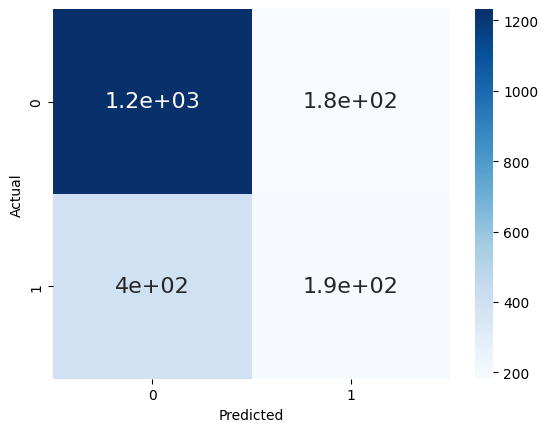

In [32]:
#Matriz de confusão 
df_cm=pd.DataFrame(confusion_matrix(y_test,y_pred),columns=np.unique(y_test),index=np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

In [33]:
y_pred_prob = model.predict_proba(X_test_pro)[:, 1]  # Probabilidade teste Positivo do resultado genético
auc = roc_auc_score(y_test, y_pred_prob)

print("Área sob a curva ROC (AUC):", auc)

Área sob a curva ROC (AUC): 0.6584387717172497


In [34]:
## Curva ROC
from sklearn.metrics import roc_curve, roc_auc_score

# Calcula a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Área sob a curva ROC
roc_auc = roc_auc_score(y_test, y_pred_prob)

fig = go.Figure()

fig.add_trace(go.Scatter(x=fpr, y=tpr,
                    mode='lines',
                    name=f'ROC curve (AUC = {roc_auc:.2f})'))

fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1],
                    mode='lines',
                    name='Random Guessing',
                    line=dict(dash='dash')))

fig.update_layout(title='Curva ROC',
                  xaxis_title='Taxa de Falso Positivo',
                  yaxis_title='Taxa de Verdadeiro Positivo',
                  legend=dict(x=0.7, y=0.2))

fig.show()
